In [11]:
import os
import time
import torch
import torchvision
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms, models as tv_models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the paths

In [12]:
base_dir = "C:/Users/danis/Coding/crop-disease-recognition-cnn"
preprocessing_dir = os.path.join(base_dir, "Preprocessing")
models_dir = os.path.join(base_dir, "Models")

# Load datasets

In [13]:
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(os.path.join(preprocessing_dir, 'test'), data_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load class names

In [14]:
class_names = test_dataset.classes

# Use GPU if available

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to load model

In [16]:
def load_model(model_name, num_classes):
    if model_name == 'resnet50':
        model = tv_models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.load_state_dict(torch.load(os.path.join(models_dir, 'resnet50_best_model.pth')))
    elif model_name == 'vgg16':
        model = tv_models.vgg16(weights=None)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        model.load_state_dict(torch.load(os.path.join(models_dir, 'vgg16_best_model.pth')))
    elif model_name == 'efficientnet_b0':
        model = tv_models.efficientnet_b0(weights=None)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        model.load_state_dict(torch.load(os.path.join(models_dir, 'efficientnet_b0_best_model.pth')))
    model = model.to(device)
    return model

# Function to evaluate model

In [17]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    start_time = time.time()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    end_time = time.time()
    eval_time = end_time - start_time
    return all_labels, all_preds, eval_time

# Function to calculate metrics

In [18]:
def calculate_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

# Function to plot confusion matrix

In [19]:
def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Evaluate all models

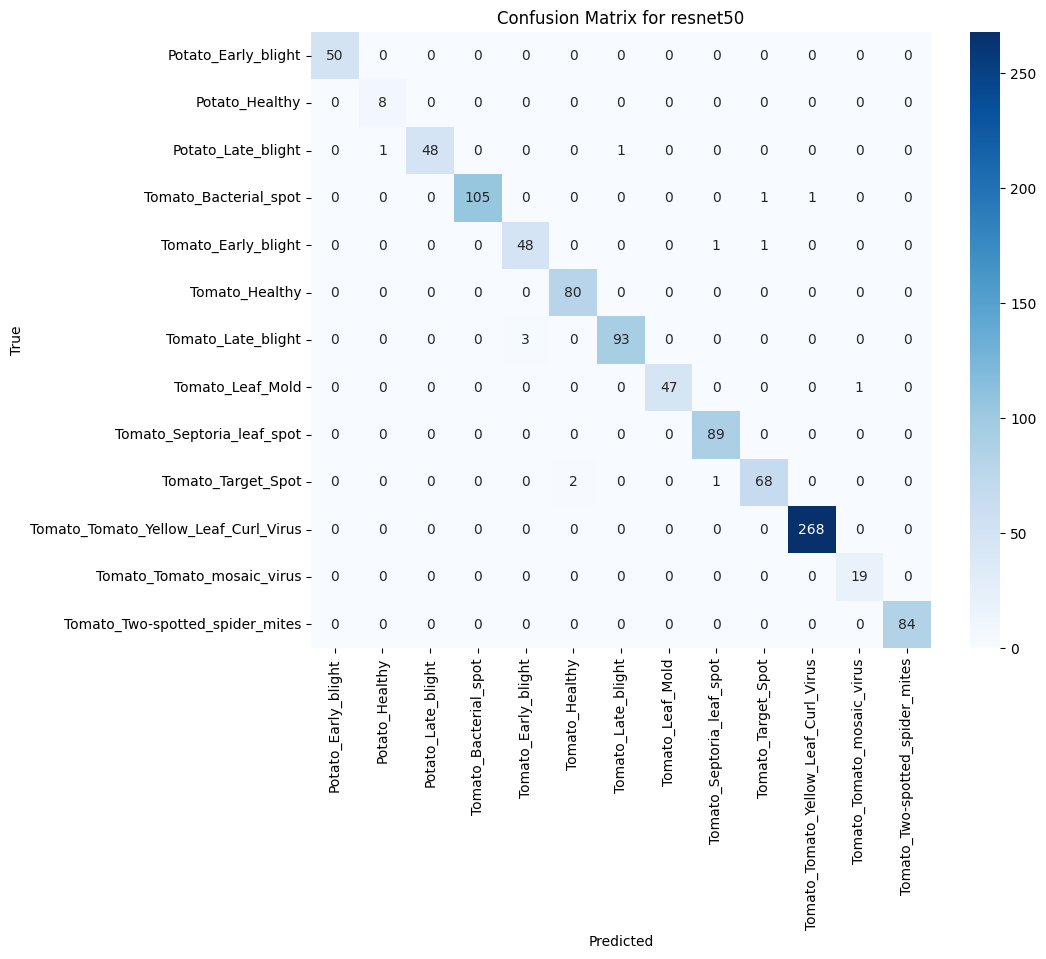

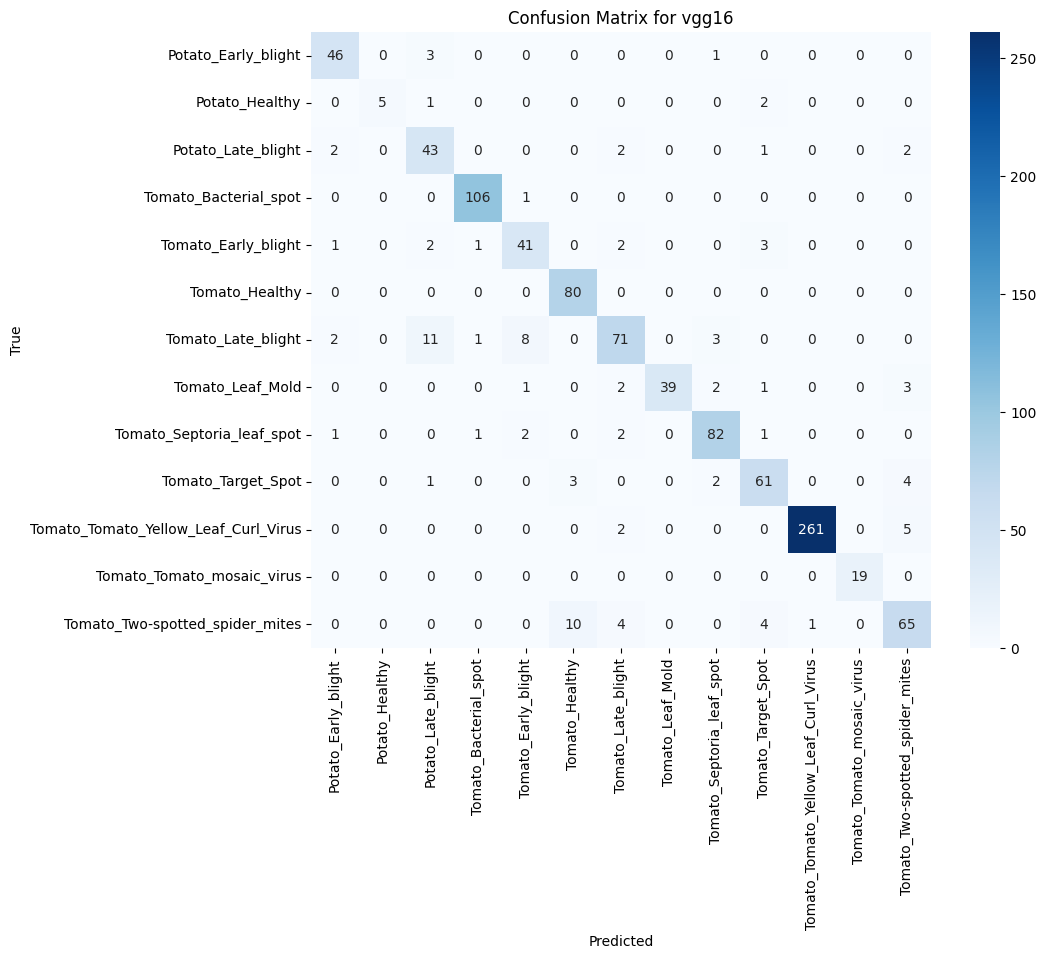

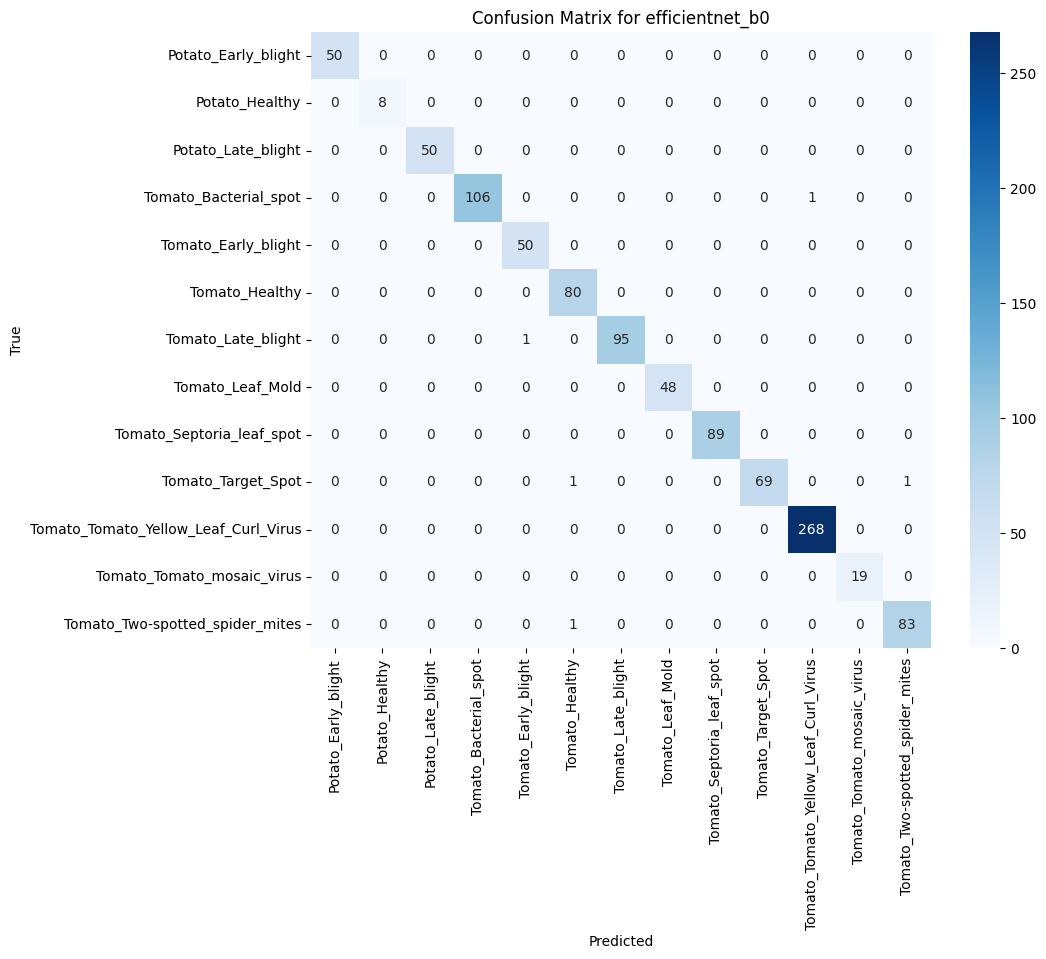

In [20]:
model_names = ['resnet50', 'vgg16', 'efficientnet_b0']
results = {}

for model_name in model_names:
    model = load_model(model_name, len(class_names))
    labels, preds, eval_time = evaluate_model(model, test_loader)
    accuracy, precision, recall, f1 = calculate_metrics(labels, preds)
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'eval_time': eval_time
    }
    plot_confusion_matrix(labels, preds, f'Confusion Matrix for {model_name}')

# Print results

In [21]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Evaluation Time: {metrics['eval_time']:.4f} seconds")
    print("-" * 30)

Model: resnet50
Accuracy: 0.9873
Precision: 0.9875
Recall: 0.9873
F1 Score: 0.9873
Evaluation Time: 21.1465 seconds
------------------------------
Model: vgg16
Accuracy: 0.9010
Precision: 0.9046
Recall: 0.9010
F1 Score: 0.9008
Evaluation Time: 15.1384 seconds
------------------------------
Model: efficientnet_b0
Accuracy: 0.9951
Precision: 0.9952
Recall: 0.9951
F1 Score: 0.9951
Evaluation Time: 11.0132 seconds
------------------------------


# Visualize the results

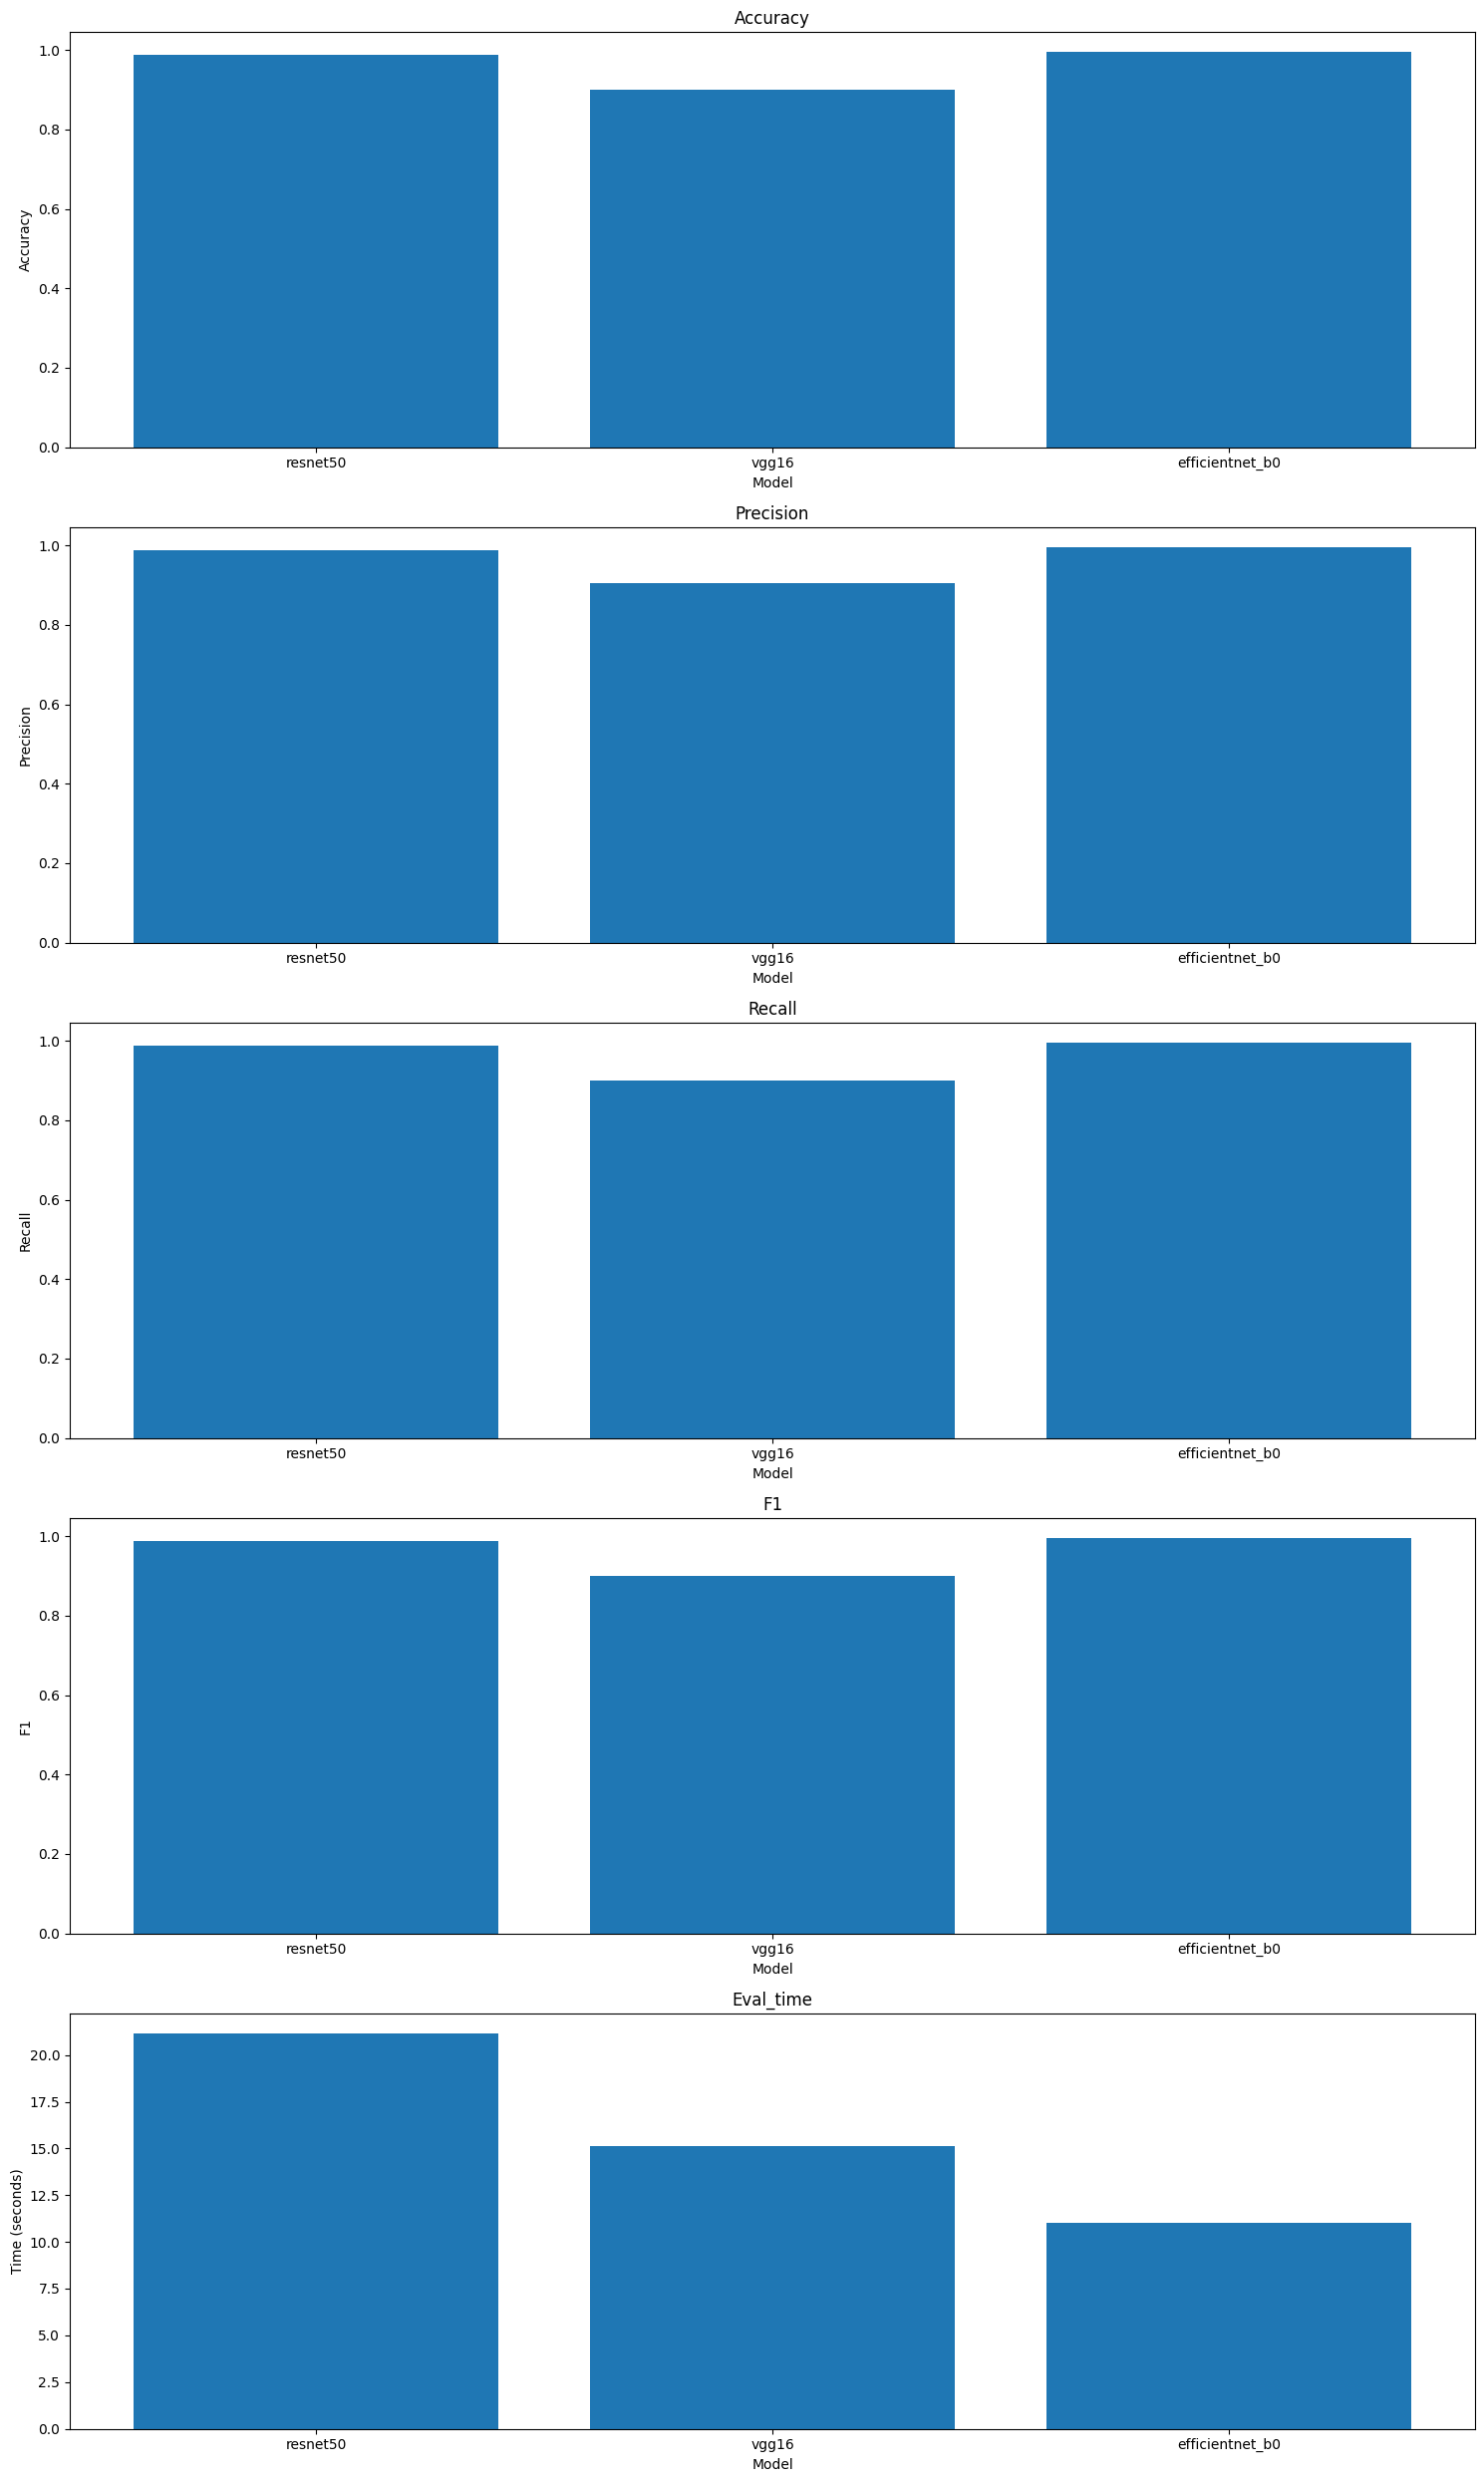

In [22]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'eval_time']
n_metrics = len(metrics)

plt.figure(figsize=(15, 5 * n_metrics))

for i, metric in enumerate(metrics):
    plt.subplot(n_metrics, 1, i + 1)
    plt.bar(results.keys(), [results[m][metric] for m in results])
    plt.title(metric.capitalize())
    plt.ylabel(metric.capitalize())
    plt.xlabel('Model')
    if metric == 'eval_time':
        plt.ylabel('Time (seconds)')
        
plt.tight_layout()
plt.show()